In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import netket as nk
import numpy as np
import jax.numpy as jnp

from netket.operator.spin import sigmax, sigmay, sigmaz

import sys 
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/models')
sys.path.append('/scratch/samiz/GPU_ViT_Calcs/StructureFactor_Calcs')
from Afm_Model_functions import *
from vmc_2spins_sampler import Exchange_OP
import  ViT_2d_Vers3_XavierUniform as vitX 

import pickle

import jax
import matplotlib.pyplot as plt


# from Structure_Factor import *



the goal of this notebook is to try to create the attention maps to see if we can read out some correaltions from there!!

In [3]:
from netket.utils import HashableArray

L = 6

# hi2d = nk.hilbert.Spin(s=0.5, N=L**2, constraint=Mtot_Parity_Constraint(parity=0))
TriGraph36 = nk.graph.Triangular(extent = [L,L], pbc = True)

pHa = {
    'L': L,
    'J1' : 1.0,
    'J2' : 0.4375,
    'Dxy': 0.75,
    'd' : 0.1,
    'dprime' : 0.5,
    'sublattice': [0,1,2,3,8,9,10,11]
}

Ha36, hi2d36 = H_afmJ123(L=pHa['L'], J1=pHa['J1'], J2=pHa['J2'], J3=pHa['J2'], Dxy=pHa['Dxy'], d=pHa['d'], dprime=pHa['dprime'], return_space=True, parity=0., sublattice = None, make_rotation=False, exchange_XY=False)
print('the Hilbert space is: ', hi2d36)
XX36= Exchange_OP(hi2d36, TriGraph36)

sa_Ha36 = nk.sampler.MetropolisHamiltonian(hilbert=hi2d36, hamiltonian=XX36, n_chains=32, sweep_size = 3* hi2d36.size)
sa_ex36 = nk.sampler.MetropolisExchange(hilbert=hi2d36, graph=TriGraph36, n_chains=32, sweep_size=3*hi2d36.size)
rules5050_36 = nk.sampler.rules.MultipleRules(rules = [sa_Ha36.rule, sa_ex36.rule], probabilities = [0.5, 0.5])

sa_HaEx5050_36 = nk.sampler.MetropolisSampler(hi2d36, rules5050_36, n_chains=32, sweep_size=3*hi2d36.size)

pVit = {
    'd': 24,
    'h': 6,
    'nl': 1,
    'Dtype': jnp.float64,
    'hidden_density': 1,
    'L': L,
    'Cx': 2,
    'Cy': 2,
    'patch_arr': HashableArray(jnp.array([[0,1,6,7], [2,3,8,9], [4,5,10,11],
                                           [12,13,18,19], [14,15,20,21], [16,17,22,23],
                                             [24,25,30,31], [26,27,32,33], [28,29,34,35]])),
}

m_Vit = vitX.ViT_2d(patch_arr=HashableArray(pVit['patch_arr']), embed_dim=pVit['d'], num_heads=pVit['h'], nl=pVit['nl'],
                                Dtype=pVit['Dtype'], L=pVit['L'], Cx=pVit['Cx'], Cy=pVit['Cy'], hidden_density=pVit['hidden_density'])



vs_vit = nk.vqs.MCState(sampler=sa_HaEx5050_36, model=m_Vit, n_samples=2**12, n_discard_per_chain=16)
with open('/scratch/samiz/GPU_ViT_Calcs/StructureFactor_Calcs/log_vit_sampler_HaEx_5050.pickle', 'rb') as handle:
    params = pickle.load(handle)

vs_vit.variables = params



the Hilbert space is:  Spin(s=1/2, N=36, ordering=inverted, <vmc_2spins_sampler.Mtot_Parity_Constraint object at 0x7f62f86e2990>)


In [4]:
vs_vit.parameters.keys()
vs_vit.parameters['ViT_real_0'].keys()
vs_vit.parameters['ViT_real_0']['Transformer_Encoder_0'].keys()
vs_vit.parameters['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0'].keys()
vs_vit.parameters['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0']['alpha'].shape

(6, 9)

In [5]:
alphas = np.abs(vs_vit.parameters['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0']['alpha'])

/tmp/ipykernel_3325113/4032990516.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


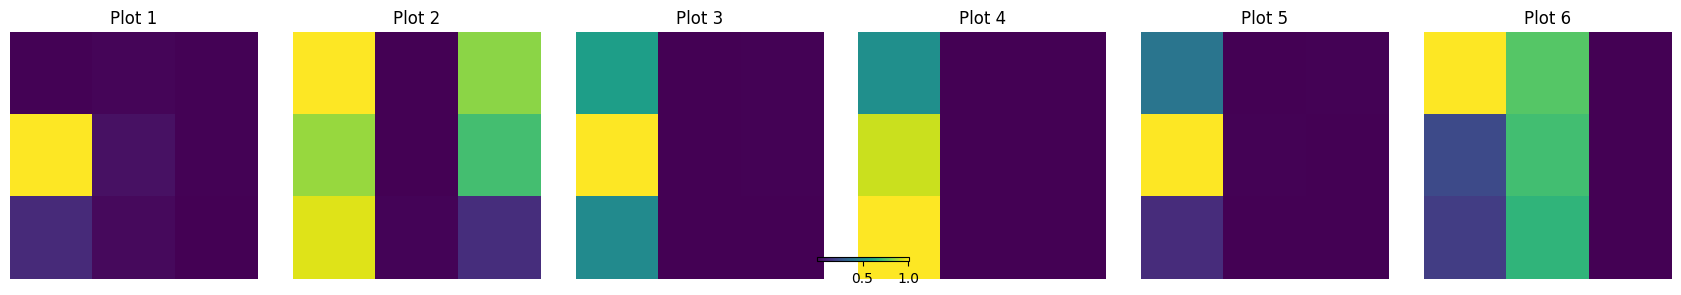

In [6]:
fig, axes = plt.subplots(1, 6, figsize=(18, 3))

for j in range(6):
    axes[j].imshow((alphas[j, :]).reshape(3, 3), cmap='viridis')
    axes[j].set_title(f'Plot {j+1}')
    axes[j].axis('off')
fig.colorbar(axes[0].imshow(alphas[0, :].reshape(3, 3), cmap='viridis'), ax=axes, orientation='horizontal', fraction=0.02, pad=0.5)
plt.tight_layout()
plt.show()

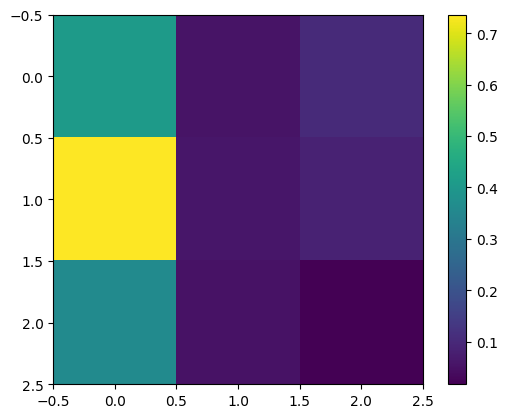

In [7]:
alphas_mean = (jnp.mean((alphas), axis=0))

plt.imshow(alphas_mean.reshape(3, 3), cmap='viridis')
plt.colorbar()

could it be that attention mechanism learns the stripe order?

In [32]:
jnp.arange(0,9).reshape(3,3)

Array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]], dtype=int64)

In [69]:
# pVit2 = {
#     'd': 24,
#     'h': 6,
#     'nl': 2,
#     'Dtype': jnp.float64,
#     'hidden_density': 1,
#     'L': L,
#     'Cx': 2,
#     'Cy': 2,
#     'patch_arr': HashableArray(jnp.array([[0,1,6,7], [2,3,8,9], [4,5,10,11],
#                                            [12,13,18,19], [14,15,20,21], [16,17,22,23],
#                                              [24,25,30,31], [26,27,32,33], [28,29,34,35]])),
# }

# m_Vit2 = vitX.ViT_2d(patch_arr=HashableArray(pVit2['patch_arr']), embed_dim=pVit2['d'], num_heads=pVit2['h'], nl=pVit2['nl'],
#                                 Dtype=pVit2['Dtype'], L=pVit2['L'], Cx=pVit2['Cx'], Cy=pVit2['Cy'], hidden_density=pVit2['hidden_density'])



# vs_vit2= nk.vqs.MCState(sampler=sa_HaEx5050_36, model=m_Vit2, n_samples=2**12, n_discard_per_chain=16)


In [8]:
alphas_nl2 = []

In [9]:
with open('/scratch/samiz/GPU_ViT_Calcs/StructureFactor_Calcs/log_vit_sampler_HaEx_5050_nl2.pickle', 'rb') as handle:
    params2 = pickle.load(handle)

alphas_nl2.append(params2['params']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0']['alpha'])
alphas_nl2.append(params2['params']['ViT_real_0']['Transformer_Encoder_1']['Self_Attention_2d_0']['alpha'])

alpha_nl2 = jnp.array(alphas_nl2)

In [10]:
alpha_nl2.shape

(2, 6, 9)

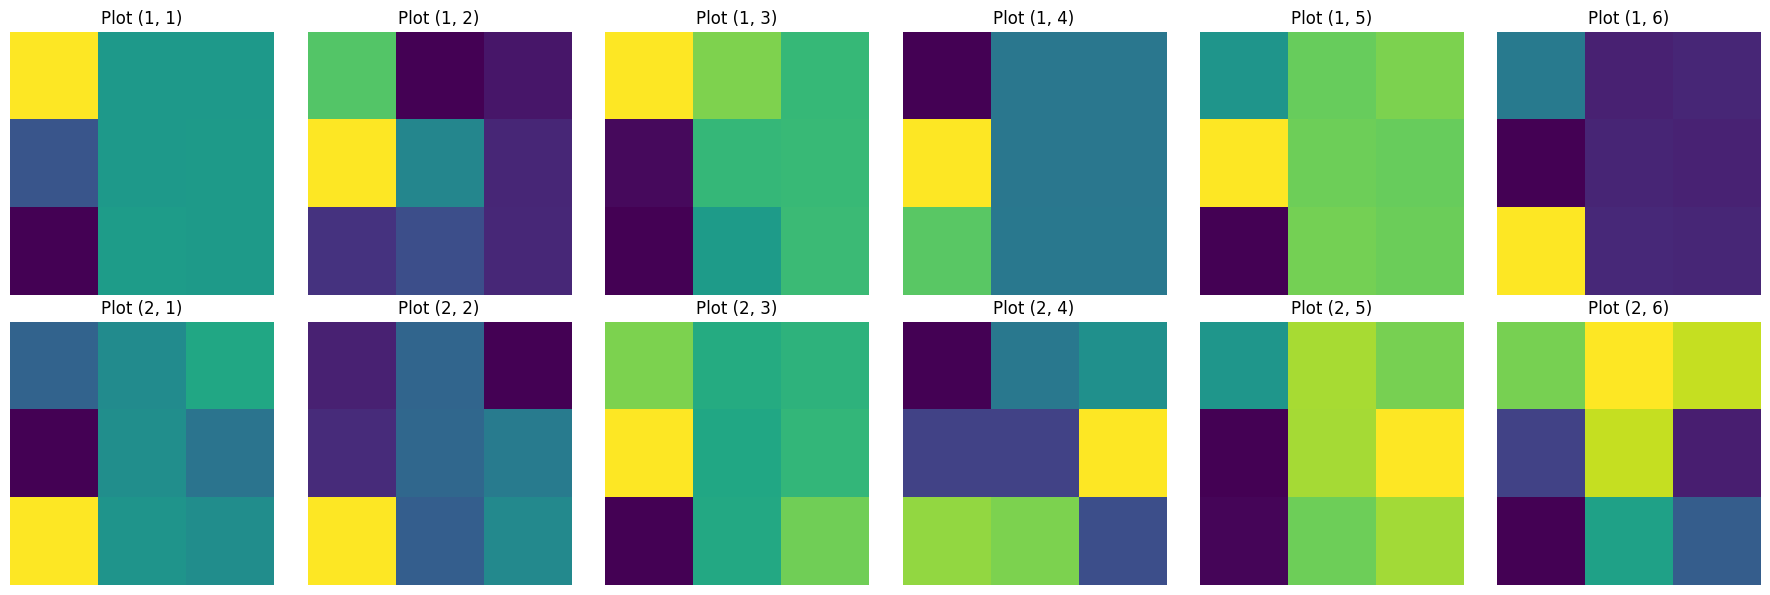

In [11]:
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(2):
    for j in range(6):
        axes[i, j].imshow(alpha_nl2[i, j, :].reshape(3, 3), cmap='viridis')
        axes[i, j].set_title(f'Plot ({i+1}, {j+1})')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

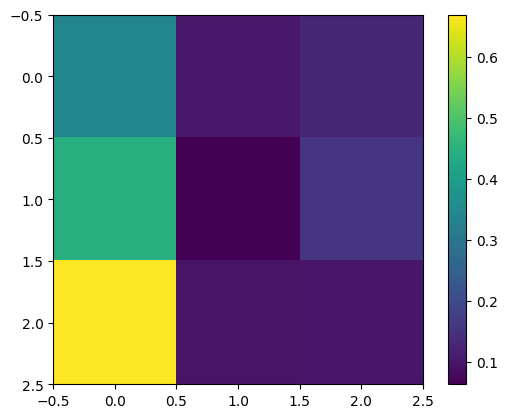

In [12]:
a_mean = jnp.mean(np.mean(np.abs(alpha_nl2), axis=1), axis=0)

plt.imshow(a_mean.reshape(3, 3), cmap='viridis')
plt.colorbar()

In [13]:
with open('/scratch/samiz/GPU_ViT_Calcs/StructureFactor_Calcs/log_vit_sampler_HaEx_3070.pickle', 'rb') as handle:
    params3070 = pickle.load(handle)


alphas12 = params3070['params']['ViT_real_0']['Transformer_Encoder_0']['Self_Attention_2d_0']['alpha']
print(alphas12.shape)

(6, 18)


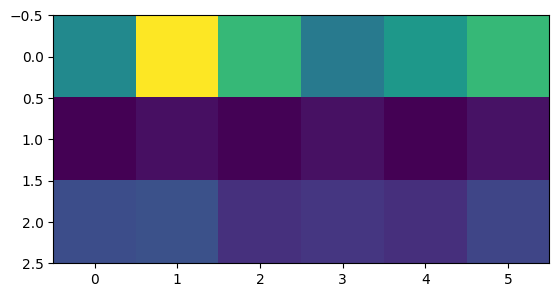

In [16]:
plt.imshow(jnp.mean(jnp.abs(alphas12), axis=0).reshape(6, 3).T, cmap='viridis')